# Do the heart rate data from the Fitbit Versa and Xiaomi Mi Band 4 meaningfully differ?
I've been wearing one on each wrist to find out.  
This is only a couple of days of data, and is mostly an excuse to draw pretty pictures.

In [1]:
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from typing import Tuple
from pprint import pprint

sns.set_style("darkgrid")

In [2]:
# Exported using Xiaomi Mi Band Tools
mifit = pd.read_csv("mifit.csv")
mifit["dateTime"] = pd.to_datetime(mifit["dateTime"])
mifit = mifit.set_index("dateTime").sort_index()
mifit = mifit.rename({"rate":"mifit"}, axis="columns").drop(columns="rateZone")

In [3]:
fitbit = None

# Grab all the fitbit files
for path in glob.glob(r"./fitbit-*.csv"):

    # Each file represents a day. Save off the day so we know how to index the data
    # From https://iccir919.github.io/pulseWatch/public/index.html
    day: str = re.match(pattern=r"\.\/fitbit-(?P<day>\d{4}-\d{2}-\d{2}).csv", string=path).group("day")
    day: pd.datetime = pd.to_datetime(day)

    df = pd.read_csv(path)
    df["Time"] = pd.to_timedelta(df["Time"])
    df["Time"] = df["Time"] + day

    df.set_index("Time", inplace=True)
    df.sort_index(inplace=True)

    if fitbit is None:
        fitbit = df
    else:
        fitbit = pd.concat([fitbit, df])

fitbit = fitbit.rename({"Heart Rate":"fitbit"}, axis="columns")
    

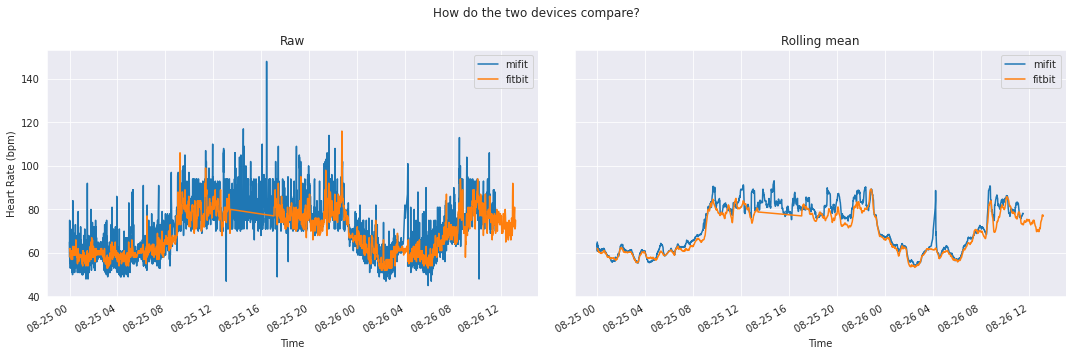

In [4]:
fig: plt.Figure
ax0: plt.Axes
ax1: plt.Axes

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,5), sharey=True)

fig.suptitle("How do the two devices compare?")

mifit.plot(ax=ax0)
fitbit.plot(ax=ax0)
ax0.set(title="Raw", ylabel="Heart Rate (bpm)")

# And lets average it out
mifit.rolling("1000s").mean().plot(ax=ax1)
fitbit.rolling("1000s").mean().plot(ax=ax1)
ax1.set(title="Rolling mean")

fig.tight_layout()
fig.show()

Ok, we have some intuition about how the two compare. Can we do better?

In [5]:
# Put rows into minute buckets
f2 = fitbit.resample("1min").mean()
m2 = mifit.resample("1min").mean()

# Get all buckets the two have in common
df2 = pd.concat([f2, m2], axis="columns").dropna()

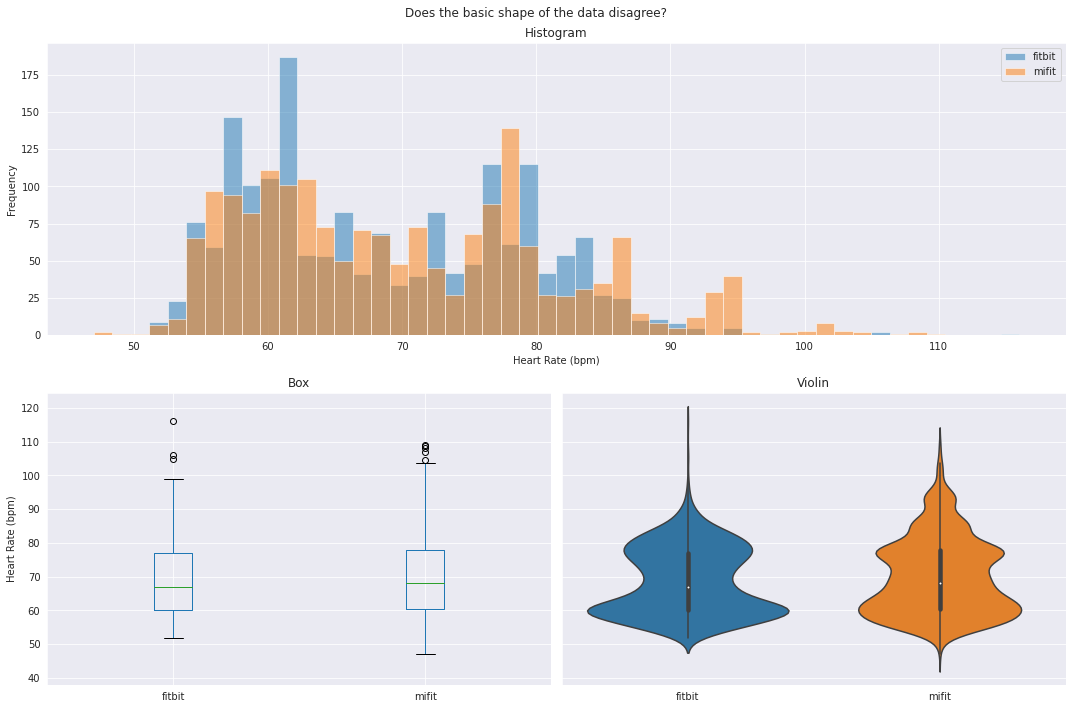

In [6]:
fig: plt.Figure = plt.figure(figsize=(15,10))

gridspec = fig.add_gridspec(nrows=2, ncols=2)

ax0 = fig.add_subplot(gridspec[0,:])
ax1 = fig.add_subplot(gridspec[1,0])
ax2 = fig.add_subplot(gridspec[1,1], sharey=ax1)

fig.suptitle("Does the basic shape of the data disagree?")

df2.plot.hist(alpha=0.5, bins=50, ax=ax0)
ax0.set(title="Histogram", xlabel="Heart Rate (bpm)")

df2.plot.box(ax=ax1)
ax1.set(title="Box", ylabel="Heart Rate (bpm)")

sns.violinplot(data=df2, ax=ax2)
ax2.set(title="Violin")

fig.tight_layout()
fig.show()

The broad shape of the data is the same.  
Note the stepping from the Mi Fit.  

Note also the data is bimodal!  
I suspect this is sleep/wake - further analysis to follow!

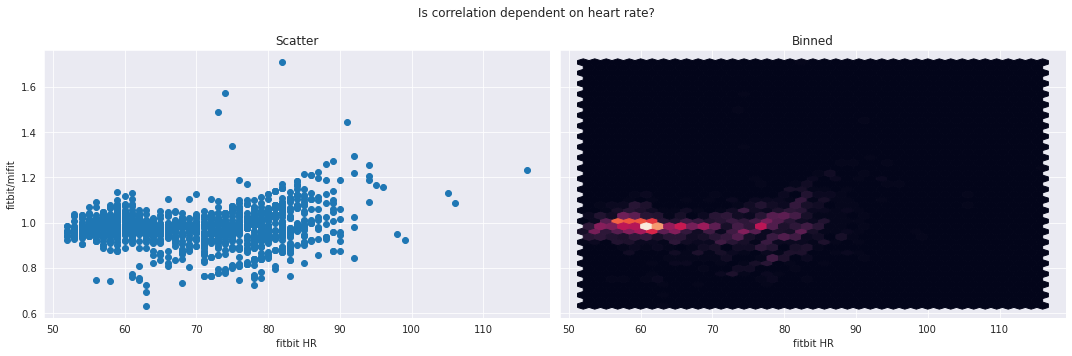

In [7]:
# How close are they to one another?

ratio = df2["fitbit"] / df2["mifit"]

fig: plt.Figure
axes: Tuple[plt.Axes]

fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)

fig.suptitle("Is correlation dependent on heart rate?")

ax = axes[0]
ax.scatter(x=df2["fitbit"], y=ratio)
ax.set(title="Scatter", xlabel="fitbit HR", ylabel="fitbit/mifit")

ax = axes[1]
ax.hexbin(x=df2["fitbit"], y=ratio, gridsize=40)
ax.set(title="Binned", xlabel="fitbit HR")

fig.tight_layout()
fig.show()


The devices correlate better at lower heart rates (best at 60bpm).  
Note that this could be due to much of the data being collected while I'm asleep.

In [8]:
# Put rows into 5 minute buckets
df3 = pd.concat([
    fitbit.resample("5min").sem().rename(columns={"fitbit":"fitbit.sem"}), 
    fitbit.resample("5min").mean().rename(columns={"fitbit":"fitbit.mean"}),
    mifit.resample("5min").sem().rename(columns={"mifit":"mifit.sem"}), 
    mifit.resample("5min").mean().rename(columns={"mifit":"mifit.mean"})
], axis="columns").sort_index().dropna()



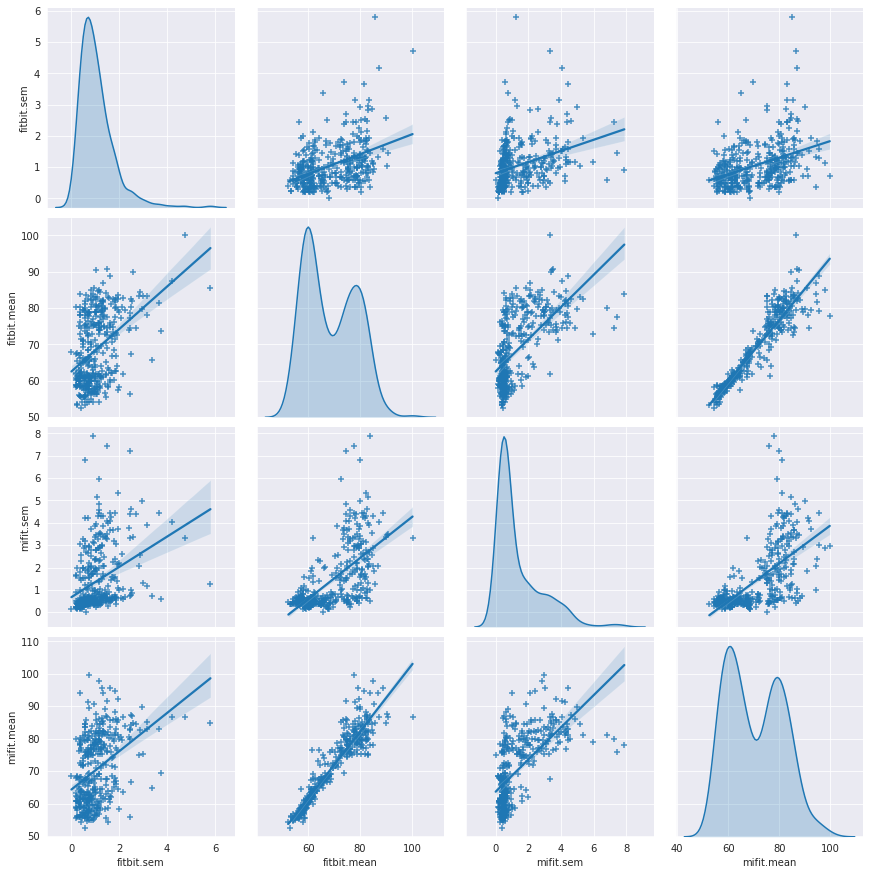

In [9]:
# How do different pairs of variables correlate?
# Note that diagonals just show distribution
sns.pairplot(data=df3, kind="reg", markers="+", diag_kind="kde", size=3)

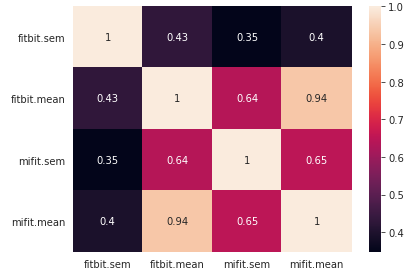

In [10]:
fig, ax = plt.subplots()
sns.heatmap(df3.corr(), annot=True, ax=ax)
fig.tight_layout()
fig.show()

# Key takeaways
- The devices strongly agree with one another on what your heart rate is
  - That is, taking the average at 5-minute intervals, `r=0.94`
- The Mi Fit is far more variable with its measurements
  - Roughly 3 times the standard error about the mean (I think?)
- Both are more variable at higher heart rates, but the Mi Fit more so
- Both disagree more at higher heart rates